Google drive connection, installs necessary for notebook

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-9e706f4e-bb82-e429-aba5-3cad6aa6833b)


In [ ]:
import sys
import os

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/MyDrive/NBME/input")

!pip install -qq --upgrade pip
!pip install transformers sentencepiece datasets -qq --no-cache-dir

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
class ModelParams:
    pt_batch_size = 16      # Batch size when pre-training with MLM
    init_batch_size = 16    # For when model has just our beginning supervised data
    fin_batch_size = 32     # For when model has semi-supervised data
    eval_batch_size = 40    # For model evaluation, (no backward pass)
    sub_batch_size = 4      # For large transformers GPU RAM can only handle batch sizes of 4 during MLM
    max_length = 460        # Max length found from previous tokenizations
    rand_seed = 42
    num_workers = 2         # setting num_workers > 0 can sometimes cause freezes
    pin_mem = True if \
      num_workers > 0 else False
    num_epochs = 12
    n_folds = 5             # Num folds for cross validation
    model_type = 'roberta'  # Fine tune the different models on separate notebooks

# Imports, Utils, and Files

Fast tokenizer borrowed from Thanh Nguyen's Fast Tokenizer with files [here](https://www.kaggle.com/datasets/thanhns/deberta-v2-3-fast-tokenizer) and [here](https://www.kaggle.com/datasets/thanhns/deberta-tokenizer).

In [ ]:
# The following is necessary if you want to use the fast tokenizer for deberta v2 or v3
# This must be done before importing transformers
import shutil
from pathlib import Path
import transformers

transformers_path = Path(transformers.__file__.replace("/__init__.py", ""))
input_dir = Path("../input/deberta-v2-3-fast-tokenizer")

convert_file = input_dir / "convert_slow_tokenizer.py"
conversion_path = transformers_path/convert_file.name

if conversion_path.exists(): conversion_path.unlink()

shutil.copy(convert_file, transformers_path)
deberta_v2_path = transformers_path / "models" / "deberta_v2"

for filename in ['tokenization_deberta_v2.py', 'tokenization_deberta_v2_fast.py']:
    filepath = deberta_v2_path/filename
    if filepath.exists(): filepath.unlink()

    shutil.copy(input_dir/filename, filepath)         

In [ ]:
import gc
import ast
import random
from datetime import date, datetime

import numpy as np # linear algebra
import pandas as pd # data processing
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1300)
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from transformers.models.deberta_v2.tokenization_deberta_v2_fast import DebertaV2TokenizerFast
from transformers import RobertaTokenizerFast, AutoModel, AutoConfig
from transformers import AdamW, get_scheduler
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F

%env TOKENIZERS_PARALLELISM=true
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from pynvml import * # for memory querying
nvmlInit()
H = nvmlDeviceGetHandleByIndex(0)

env: TOKENIZERS_PARALLELISM=true


In [ ]:
def seed_everything(seed=0):
    '''
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.
    '''
    random.seed(seed)
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # When running on the CuDNN backend, two further options must be set
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(seed=ModelParams.rand_seed)

In [ ]:
roberta_tokenizer = RobertaTokenizerFast.from_pretrained('roberta-large')
deberta_tokenizer = DebertaV2TokenizerFast.from_pretrained('../input/deberta-tokenizer')
# Note: offset mapping for these decoders are the same, but DeBERTa tokenizer decodes single tokens without a space, multiple tokens with a space between them

if ModelParams.model_type == 'roberta':
    cur_tokenizer = roberta_tokenizer

    pt_folder = '../public_models/roberta_mlm'
    if not os.path.exists(pt_folder): os.makedirs(pt_folder)
    init_folder = '../public_models/roberta_initial'
    if not os.path.exists(init_folder): os.makedirs(init_folder)
    fin_folder = '../public_models/roberta_final'
    if not os.path.exists(fin_folder): os.makedirs(fin_folder)
elif ModelParams.model_type == 'deberta':
    cur_tokenizer = deberta_tokenizer

    pt_folder = '../public_models/deberta_mlm'
    if not os.path.exists(pt_folder): os.makedirs(pt_folder)
    init_folder = '../public_models/deberta_initial'
    if not os.path.exists(init_folder): os.makedirs(init_folder)
    fin_folder = '../public_models/deberta_final'
    if not os.path.exists(fin_folder): os.makedirs(fin_folder)
else: # public model
    cur_tokenizer = deberta_tokenizer

    init_folder = '../public_models/deberta-v3-large-5-folds-public'

# Dataset creation

### Data helper functions

In [ ]:
def print_gpu_memory():
    info = nvmlDeviceGetMemoryInfo(H)
    print(f'total    : {info.total}')
    print(f'free     : {info.free}')
    print(f'used     : {info.used}')

def write_to_file(file_path, print_string, option='a'):
    # Need to write to file in this manner due to Colab's synchronization with Drive
    f = open(file_path, option)
    f.write(print_string)
    f.close()
    del f
    gc.collect()

def only_save_best_models(best_losses, epoch, loss, best_loss, fold_folder, model, optimizer=None):
    '''
    Function for managing data storage. Given the inputs, keep only the three best models
    in storage in terms of the loss (train_loss or val_loss).

    Returns: min(loss, best_loss)
    '''
    best_losses.append((epoch, loss))
    best_losses.sort(key=lambda x: x[1])
    epoch_folder = f"{fold_folder}/epoch_{epoch+1}"
    # Only want to save three best models to save memory
    if len(best_losses) > 3:
        popped = best_losses.pop(3)
        if popped[0] != epoch:
            shutil.rmtree(f"{fold_folder}/epoch_{popped[0]+1}")
            if not os.path.exists(epoch_folder): os.makedirs(epoch_folder)
            torch.save(model.state_dict(), epoch_folder+"/model.pth")
            if optimizer is not None: torch.save(optimizer.state_dict(), epoch_folder+"/optim.pth")
    else:
        if not os.path.exists(epoch_folder): os.makedirs(epoch_folder)
        torch.save(model.state_dict(), epoch_folder+"/model.pth")
        if optimizer is not None: torch.save(optimizer.state_dict(), epoch_folder+"/optim.pth")
    return min(loss, best_loss)

def create_k_fold_col(train_df):
    skf = StratifiedKFold(n_splits=ModelParams.n_folds, shuffle=True, random_state=ModelParams.rand_seed)
    if "gold" in train_df.columns:
        train_df["stratify_on"] = train_df["case_num"].astype(str) + train_df["feature_num"].astype(str) + train_df["gold"].astype(str)
    else:
        train_df["stratify_on"] = train_df["case_num"].astype(str) + train_df["feature_num"].astype(str)
    train_df["fold"] = -1      # Create a column to remember the fold
    for fold, (_, valid_idx) in enumerate(skf.split(np.zeros(len(train_df)), y=train_df["stratify_on"])):
        train_df.loc[valid_idx, "fold"] = fold
    return train_df

def location_list(string_locs):
    # example: ['0 1', '3 4', '4 4;5 6'] -> [(0, 1), (3, 4), (4, 4), (5, 6)]
    loc_list = []
    for loc_string in string_locs:
        for section in loc_string.split(';'):
            start, end = section.split()
            loc_list.append((int(start), int(end)))
    return loc_list

def calculate_f1_metrics(predictions, references, attention_mask):
    '''
    Given a batch of predictions, references, and their attention_masks, return
    the f1 metrics true_positive, false_positive, and false_negative from the batch.
    
    Args:
        predictions (tensor - list of list of ints): Predictions for each token in each sentence of the batch
        references (tensor - list of list of ints): Labels for each token in each sentence of the batch
        attention_mask (tensor - list of list of ints): Attention mask for tokens in the batch

    Returns:
        true_positive, false_positive, false_negative: ints for each of these values (wrt desired label 1)
    '''
    predictions = predictions * attention_mask
    references = references * attention_mask
    true_positive = torch.sum(predictions*references) + 0.1
    false_positive = torch.sum(predictions*(1-references)) + 0.1
    false_negative = torch.sum((1-predictions)*references) + 0.1
    return int(true_positive), int(false_positive), int(false_negative)

def convert_to_labels(offset_mapping, loc_list):
    '''
    Given a bunch of offset_mappings, return a tensor with label 1 for each token
    contained within the boundaries of a location in location_list.
    
    Args:
        offset_mapping (list of tuples of two ints): Token spans.
        loc_list (list of tuples of two ints): Char spans in sentence with positive feature label.

    Returns:
        torch tensor [ModelParams.max_length]: Binarized token label.
    '''
    labels = torch.zeros(ModelParams.max_length, dtype=torch.int64)
    if len(loc_list) == 0: return labels
    for i in range(ModelParams.max_length):
        if offset_mapping[i][0] >= loc_list[0][0]-1 and offset_mapping[i][1] <= loc_list[-1][1]:
            for loc in loc_list:
                if offset_mapping[i][0] >= loc[0]-1:
                    if offset_mapping[i][1] <= loc[1]:
                        labels[i] = 1
                else: break
    return labels

def get_char_probs(texts, predictions, offset_mappings):
    '''
    From the probabilities for individual tokens, generate probabilities for each
    of the characters using the offset mappings.
    '''
    results = [np.zeros(len(t)) for t in texts]
    for i, (prediction, offset_mapping) in enumerate(zip(predictions, offset_mappings)):
        prediction = prediction[:len(offset_mapping)]
        for idx, (pred, offset_tuple) in enumerate(zip(prediction, offset_mapping)):
            start = offset_tuple[0]
            end = offset_tuple[1]
            results[i][start:end] = pred
    return results

def get_results(prediction, th=0.5):
    '''
    From the probabilities for individual characters, generate locations for words.
    '''

    def return_word_spans(text): # _Standard_ tokenization function for returning spans of individual words and punctuation
        good_punctuation = set(';')
        punctuation = set([',', '.', '?', '!', '/', ':', '-', '>', '<', '~', '[', ']', '_', ')', '*', '\\', '=', '(', '&', '#', '$', '@', '+', '\n', '\t'])
        word_spans = []
        prev_punc = -1
        for i in range(len(text)):
            if text[i] in punctuation:
                if (i - prev_punc) != 1: word_spans.append((prev_punc+1, i))
                word_spans.append((i, i+1))
                prev_punc = i
            elif text[i].isspace() or text[i] in good_punctuation:
                if (i - prev_punc) != 1: word_spans.append((prev_punc+1, i))
                prev_punc = i
            elif text[i] == '"':
                if i+1 != len(text) and text[i+1] == '.': continue
                if (i - prev_punc) != 1: word_spans.append((prev_punc+1, i))
                prev_punc = i
            elif text[i] == "'" and not (i-1 >= 0 and text[i-1].isalpha() and i+1 < len(text) and text[i+1].isalpha()):
                if (i - prev_punc) != 1: word_spans.append((prev_punc+1, i))
                word_spans.append((i, i+1))
                prev_punc = i
        return word_spans

    def merge_spans(predictions, word_spans): # allows word spans to include spaces by merging consecutive word spans that are both inside the label
        results = []
        prev_word_inside = False
        for word in word_spans:
            label_prob = np.mean(predictions[word[0]:word[1]])
            if label_prob >= th: 
                if prev_word_inside: results.append((results.pop()[0], word[1]))
                else: results.append(word)
                prev_word_inside = True
            else: prev_word_inside = False
        results = [f"{tup[0]} {tup[1]}" for tup in results]
        results = ";".join(results)
        return results

    prediction["word_spans"] = prediction["text"].apply(return_word_spans)
    prediction["location"] = prediction.apply(lambda x: merge_spans(x["predictions"], x["word_spans"]), axis=1)
    prediction["id"] =  prediction.apply(lambda x: str(x["pn_num"]).rjust(5, '0') + '_' + str(x["feature_num"]).rjust(3, '0'), axis=1)
    prediction = prediction[['id', 'location']]

    return prediction

def get_char_locations(x, text):
    # Gold character labels as a numpy array (len of text)
    actual_locations = np.zeros(len(text))
    for offset_tuple in location_list(x):
        start = offset_tuple[0]
        end = offset_tuple[1]
        actual_locations[i][start:end] = 1
    return actual_locations

def produce_same_len_predictions(model_type, dataset, training_section="initial"):
    # Produce similar length predictions as public Kaggle model has a different max_length
    prefix = ""
    if dataset == "train": prefix = "train_"

    if 'kaggle' not in model_type:
        prediction_df = pd.read_csv(f"../public_models/{model_type}_{training_section}/{prefix}predictions.csv")
        prediction_df["predictions"] = prediction_df["predictions"].apply(lambda x: np.array([float(i) for i in x[1:-1].split()]))
        max_len_preds = np.array(prediction_df["predictions"])
    else:
        prediction_df = pd.read_csv(f"../public_models/deberta-v3-large-5-folds-public/{prefix}predictions.csv")
        prediction_df["predictions"] = prediction_df["predictions"].apply(lambda x: np.array([float(i) for i in x[1:-1].split()]))
        max_len_preds = list(prediction_df["predictions"])
        for index, row in enumerate(predictions[0]):
            newlen = len(row) - len(max_len_preds[index])
            max_len_preds[index] = np.concatenate([max_len_preds[index], np.ones(newlen)*0.335]) # 0.335 is ~ threshold value for Kaggle predictions
    return max_len_preds, prediction_df

### Dataset annotation error cleanup

In [ ]:
# This function just cleans up some of the clear annotation errors
def clean_datasets(symptoms, pn_notes, train_df):
    symptoms.loc[27, 'feature_text'] = "last pap smear 1 year ago"

    train_df.loc[[338], 'location'] = '["764 783"]'
    train_df.loc[[621], 'location'] = '["77 100", "398 420"]'
    train_df.loc[[655], 'location'] = '["285 292;301 312", "285 287;296 312"]'
    train_df.loc[[1262], 'location'] = '["551 557;565 580"]'
    train_df.loc[[1265], 'location'] = '["131 135;181 212"]'
    train_df.loc[[1424], 'location'] = '["74 88;109 129"]'
    train_df.loc[[1591], 'location'] = '["176 184;201 212"]'
    train_df.loc[[1615], 'location'] = '["249 257;271 288"]'
    train_df.loc[[1664], 'location'] = '["822 824;907 924"]'
    train_df.loc[[1714], 'location'] = '["101 129"]'
    train_df.loc[[1929], 'location'] = '["531 539;549 561"]'
    train_df.loc[[2134], 'location'] = '["540 560;581 593"]'
    train_df.loc[[2191], 'location'] = '["32 57"]'
    train_df.loc[[2553], 'location'] = '["308 317;376 384"]'
    train_df.loc[[3124], 'location'] = '["549 557"]'
    train_df.loc[[3858], 'location'] = '["102 123", "102 112;125 141", "102 112;143 157", "102 112;159 171"]'
    train_df.loc[[4373], 'location'] = '["33 45"]'
    train_df.loc[[4763], 'location'] = '["5 16"]'
    train_df.loc[[4782], 'location'] = '["175 194"]'
    train_df.loc[[4908], 'location'] = '["700 723"]'
    train_df.loc[[6016], 'location'] = '["225 250"]'
    train_df.loc[[6192], 'location'] = '["46 69", "197 218;236 260"]'
    train_df.loc[[6380], 'location'] = '["480 482;507 519", "480 482;499 503;512 519", "480 482;521 531", "480 482;533 545", "480 482;564 582"]'
    train_df.loc[[6562], 'location'] = '["290 320;327 337", "290 320;342 358"]'
    train_df.loc[[6862], 'location'] = '["288 296;324 363"]'
    train_df.loc[[7022], 'location'] = '["133 182"]'
    train_df.loc[[7422], 'location'] = '["102 125"]'
    train_df.loc[[8876], 'location'] = '["481 483;533 552"]'
    train_df.loc[[9027], 'location'] = '["92 102", "123 164"]'
    train_df.loc[[9875], 'location'] = '["151 156", "163 171", "221 225"]'
    train_df.loc[[9938], 'location'] = '["89 117", "122 138"]'
    train_df.loc[[9973], 'location'] = '["344 361"]'
    train_df.loc[[10513], 'location'] = '["600 623"]'
    train_df.loc[[11551], 'location'] = '["386 400;433 461"]'
    train_df.loc[[11677], 'location'] = '["160 201"]'
    train_df.loc[[12124], 'location'] = '["325 337;349 366"]'
    train_df.loc[[12279], 'location'] = '["405 459;488 524"]'
    train_df.loc[[12289], 'location'] = '["353 400;488 524"]'
    train_df.loc[[13238], 'location'] = '["293 307", "321 331"]'
    train_df.loc[[13297], 'location'] = '["182 221", "182 213;225 234"]'
    train_df.loc[[13299], 'location'] = '["71 96"]'
    train_df.loc[[13845], 'location'] = '["86 94;230 256", "86 94;237 256"]'
    train_df.loc[[14083], 'location'] = '["56 64;156 179"]'

    return symptoms, pn_notes, train_df

### Data loading and torch dataset creation

In [ ]:
USE_SMALL_DEBUG_DATASET = False

# Data directory
DATA_DIR = '../input/nbme-score-clinical-patient-notes/'

symptoms = pd.read_csv(DATA_DIR + 'features.csv')
pn_notes = pd.read_csv(DATA_DIR + 'patient_notes.csv')
train_df = pd.read_csv(DATA_DIR + 'train.csv')

# An idea of the datasets
print(symptoms.loc[0:1, :])
print(pn_notes.loc[0:1, :])
print(train_df.loc[0:1, :])

train_df.drop(['id', 'annotation'], axis=1, inplace=True)

symptoms['feature_text'] = symptoms['feature_text'].str.replace('-', ' ').str.replace(" OR ", "; ")
symptoms["feature_text"] = symptoms["feature_text"].apply(lambda x: x.lower())
pn_notes["pn_history"] = pn_notes["pn_history"].apply(lambda x: x.lower())

# Clean up some clear annotation errors
symptoms, pn_notes, train_df = clean_datasets(symptoms, pn_notes, train_df)

train_df['location'] = train_df['location'].apply(lambda x: ast.literal_eval(x))   # train_df['location'][index] has format "["1 2"]"

if USE_SMALL_DEBUG_DATASET:
    _, train_df = train_test_split(train_df, test_size=0.01, random_state=42)
    symptoms = symptoms.merge(train_df, how='inner', on=['case_num', 'feature_num'])
    symptoms.drop(columns=['location', 'pn_num'], inplace=True)
    symptoms = symptoms.groupby(['case_num', 'feature_num'], as_index=False).first()
    pn_notes = pn_notes.merge(train_df, how='inner', on=['case_num', 'pn_num'])
    pn_notes.drop(columns=['location', 'feature_num'], inplace=True)
    pn_notes = pn_notes.groupby(['case_num', 'pn_num'], as_index=False).first()
    ModelParams.n_folds = 3
    train_df.reset_index(inplace=True, drop=True)
    symptoms.reset_index(inplace=True, drop=True)
    pn_notes.reset_index(inplace=True, drop=True)
    print(len(train_df))
    print(len(symptoms))
    print(len(pn_notes))

train_dataset = symptoms.merge(pn_notes, how='outer', on=['case_num'])

# Cross entropy weights, making use of the natural balance between the ones and
# the zeros in the dataset of 69.4.
ce_weights = torch.tensor([1, torch.log(torch.tensor(69.4))], device=device)

# Dataset class for token-wise labeled data creation
class PatientNotesDataset(Dataset):
    
    def __init__(self, train_dataset, labels, tokenizer):
        self.data = train_dataset.merge(labels, how='inner', on=['case_num', 'pn_num', 'feature_num'])
        self.data.reset_index(inplace=True, drop=True)
        self.tokenizer = tokenizer
        
    def __getitem__(self, index):
        tokenized_text = self.tokenizer(self.data['pn_history'][index],
                                        self.data['feature_text'][index],
                                           max_length=ModelParams.max_length,
                                           padding='max_length',
                                           return_offsets_mapping=True,
                                           return_tensors='pt')
        
        # returned outputs from tokenizer have batch size 1, need to reshape
        for k in tokenized_text.keys():
            tokenized_text[k] = tokenized_text[k].view(*tokenized_text[k].shape[1:])
        
        # Want to zero out the second sentence
        sep_tok_index = ModelParams.max_length-1
        for i, v in enumerate(tokenized_text['input_ids']):
            if v == self.tokenizer.sep_token_id:
                sep_tok_index = i
                break
        tokenized_text['attention_mask'][sep_tok_index+1:] = 0
        
        # Convert location to labels for tokens
        loc_list = location_list(self.data['location'][index])
        labels = convert_to_labels(tokenized_text['offset_mapping'], loc_list)
        
        return {'input_ids': tokenized_text['input_ids'], \
                'attention_mask': tokenized_text['attention_mask'].type(torch.int8), \
                'labels': labels}
        
    def __len__(self):
        return len(self.data)


# Model for token-wise classification
class TokenModel(nn.Module):

    def __init__(self, cfg, config_path=None):
        super().__init__()
        
        self.config = AutoConfig.from_pretrained(cfg, output_hidden_states=True)
        if config_path is not None:
            self.model = AutoModel.from_pretrained(config_path, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)

        if "roberta" in cfg:
            for param in self.model.parameters():
                param.requires_grad = False
        elif "deberta" in cfg:
            for param in self.model.parameters():
                param.requires_grad = False

        self.proj_size = 84   # hidden size between 2 linear layers
        self.fc1 = nn.Linear(self.config.hidden_size, self.proj_size)
        self.fc2 = nn.Linear(self.proj_size, 2)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        
        return last_hidden_states

    def forward(self, inputs):
        feature = self.feature(inputs)
        hidden = self.relu(self.fc1(self.dropout(feature)))
        output = self.fc2(self.dropout(hidden))
        output.transpose_(1,2)
        
        return output


# Model layout from Kaggle
class ScoringModel(nn.Module):
    def __init__(self, config_path=None, pretrained=False):
        super().__init__()
        
        if config_path is None:
            self.config = AutoConfig.from_pretrained("microsoft/deberta-v3-large", output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained("microsoft/deberta-v3-large", config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(self.config.hidden_size, 1)
                
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        
        return last_hidden_states

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        
        return output


# Dataset class for test-set creation
class TestDataset(Dataset):
    
    def __init__(self, train_dataset, test_samples, tokenizer, public_kaggle_model=False):
        self.data = train_dataset.merge(test_samples, how='inner', on=['case_num', 'pn_num', 'feature_num'])
        self.data.reset_index(inplace=True, drop=True)
        self.tokenizer = tokenizer
        self.public_kaggle_model = public_kaggle_model
        
    def __getitem__(self, index):
        pn_note = self.data['pn_history'][index]

        if self.public_kaggle_model: length = 354
        else: length = ModelParams.max_length

        tokenized_text = self.tokenizer(pn_note, self.data['feature_text'][index],
                                           max_length=length,
                                           padding='max_length',
                                           return_offsets_mapping=True,
                                           return_tensors='pt')
        
        # returned outputs from tokenizer have batch size 1, need to reshape
        for k in tokenized_text.keys():
            tokenized_text[k] = tokenized_text[k].view(*tokenized_text[k].shape[1:])
        
        # Want to zero out the second sentence
        sep_tok_index = ModelParams.max_length-1
        for i, v in enumerate(tokenized_text['input_ids']):
            if v == self.tokenizer.sep_token_id:
                sep_tok_index = i
                break
        tokenized_text['attention_mask'][sep_tok_index+1:] = 0
        tokenized_text['offset_mapping'] = tokenized_text['offset_mapping'][:sep_tok_index+1]
        
        return {'input_ids': tokenized_text['input_ids'], \
                'attention_mask': tokenized_text['attention_mask'].type(torch.int8), \
                'offset_mapping': tokenized_text['offset_mapping'].type(torch.int16), \
                'text': pn_note}
        
    def __len__(self):
        return len(self.data)

# print([i for i in list(globals().keys()) if len(i) > 0 and i[0] != '_'])
# del globals()['symptoms'], globals()['pn_notes']

   feature_num  case_num                                       feature_text
0            0         0  Family-history-of-MI-OR-Family-history-of-myoc...
1            1         0                 Family-history-of-thyroid-disorder
   pn_num  case_num                                         pn_history
0       0         0  17-year-old male, has come to the student heal...
1       1         0  17 yo male with recurrent palpitations for the...
          id  case_num  pn_num  feature_num                        annotation     location
0  00016_000         0      16            0  ['dad with recent heart attcak']  ['696 724']
1  00016_001         0      16            1     ['mom with "thyroid disease']  ['668 693']


# Pre-training our Language Models

In [ ]:
from transformers import RobertaForMaskedLM, DebertaV2ForMaskedLM
import random

class MLMPreTrainDataset(Dataset):

    def __init__(self, pn_notes, symptoms, tokenizer):
        pn_notes_examples = tokenizer(list(pn_notes['pn_history']),
                                           add_special_tokens=True,
                                           max_length=ModelParams.max_length,
                                           padding='max_length')
        
        self.input_ids = list(pn_notes_examples['input_ids'])
        
        symptoms_examples = tokenizer(list(symptoms['feature_text']),
                                           add_special_tokens=True,
                                           max_length=ModelParams.max_length,
                                           padding='max_length')

        for i in range(3):
            self.input_ids += list(symptoms_examples['input_ids'])

        self.tokenizer=tokenizer

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, index):
        tokens = self.input_ids[index]
        rand = torch.rand(len(tokens))
        attention_mask = (rand < 0.15) * (tokens!=self.tokenizer.cls_token_id) * (tokens!=self.tokenizer.sep_token_id) * (tokens!=self.tokenizer.pad_token_id)
        attention_mask = attention_mask.type(torch.int8)
        labels = torch.zeros(len(tokens), dtype=torch.int64)

        for i, (token) in enumerate(tokens):
            prob = rand[i]
            if prob < 0.15:
                prob /= 0.15

                # 80% randomly change token to mask token
                if prob < 0.8: labels[i] = self.tokenizer.mask_token_id

                # 10% randomly change token to random token
                elif prob < 0.9:
                    line = [i for i in self.input_ids[random.randrange(len(self.input_ids))] if i != 0]
                    labels[i] = line[random.randrange(len(line))]

                # 10% randomly change token to current token, i.e. do nothing
                else: labels[i] = tokens[i]

        return {'input_ids': torch.tensor(tokens, dtype=torch.int64), 'attention_mask': attention_mask, 'labels': labels}

'''
After running the below block of code, I realized that 1e-5 is the best learning
rate in my opinion, and moreover the training loss as calculated below is a
very close approximation to validation loss. I suppose this is because the task
is mlm, and we're predicting so many embeddings that the gradients are averaged out
and training loss is a close approximation to validation loss. So we don't need the below
code.
'''

# # Train-test split for evaluation
# symptoms_train, symptoms_eval = train_test_split(symptoms, test_size=0.15, random_state=ModelParams.rand_seed)
# pn_notes_train, pn_notes_eval = train_test_split(pn_notes, test_size=0.15, random_state=ModelParams.rand_seed)

# train_metrics_path = f"{pt_folder}/training_metrics.txt"

# # Test out a number of different learning rates
# for lr in [1e-5, 2.5e-5, 5e-5]:
#     if ModelParams.model_type == 'roberta':
#         pt_model = RobertaForMaskedLM.from_pretrained('roberta-large')
#     elif ModelParams.model_type == 'deberta':
#         pt_model = DebertaV2ForMaskedLM.from_pretrained("microsoft/deberta-v3-large")

#     if lr == 5e-5: num_epochs = 3
#     elif lr == 2.5e-5: num_epochs = 6
#     else: num_epochs = 10

#     # move the model to device
#     pt_model.to(device)
#     # Train Model
#     pt_model.train()

#     # Create the train and evaluation dataset for mlm
#     pt_train_dataset = MLMPreTrainDataset(pn_notes_train, symptoms_train, cur_tokenizer)
#     pt_eval_dataset = MLMPreTrainDataset(pn_notes_eval, symptoms_eval, cur_tokenizer)

#     pt_train_dataloader = DataLoader(dataset=pt_train_dataset, batch_size=ModelParams.pt_batch_size, shuffle=True, num_workers=ModelParams.num_workers, pin_memory=ModelParams.pin_mem)
#     pt_eval_dataloader = DataLoader(dataset=pt_eval_dataset, batch_size=ModelParams.eval_batch_size, num_workers=ModelParams.num_workers, pin_memory=ModelParams.pin_mem)

#     # Optimizer and schedules for optimizer
#     pt_optimizer = AdamW(pt_model.parameters(), weight_decay=0.01)

#     num_training_steps = num_epochs * len(pt_train_dataloader)
#     num_steps = 0
#     num_warmup_steps = num_training_steps*0.01
#     print(f"Num warmup steps: {num_warmup_steps}")

#     print(f"Running learning rate of {lr} for {num_epochs} epochs.")
#     progress_bar = tqdm(range(num_training_steps))

#     row_format ="{:<10} {:<20} {:<15}"
#     now = datetime.now()
#     dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
#     write_to_file(train_metrics_path, f"Run on {dt_string}. LR = {lr}, Epochs = {num_epochs}\n")	
#     write_to_file(train_metrics_path, row_format.format("", "Approx. train loss", "Val loss") + '\n')

#     val_losses = []

#     for epoch in range(num_epochs):
#         pt_optimizer.param_groups[0]['lr'] = pt_optimizer.param_groups[0]['lr']*0.65
#         for pt_batch in pt_train_dataloader:
#             if num_steps < num_warmup_steps:
#                 pt_optimizer.param_groups[0]['lr'] = lr*(num_steps+1)/num_warmup_steps
#                 num_steps+=1

            # num_in_batch = len(pt_batch['input_ids'])
#             num_done = 0
#             while num_done < num_in_batch:      # need to use sub_batches due to RAM
#                 num_todo = min(ModelParams.sub_batch_size, num_in_batch-num_done)
#                 sub_pt_batch = {k: v[num_done:num_done+num_todo].to(device, non_blocking=True) for k, v in pt_batch.items()}
#                 sub_loss = pt_model(**sub_pt_batch).loss*num_todo/num_in_batch
#                 sub_loss.backward()
#                 del globals()["sub_loss"], globals()["sub_pt_batch"]
#                 torch.cuda.empty_cache()
#                 num_done+=num_todo
            
#             pt_optimizer.step()
#             pt_optimizer.zero_grad(set_to_none=True)
#             progress_bar.update(1)

#         # Every epoch print metrics, save if necessary
#         pt_model.eval()
#         with torch.no_grad():
#             # compute train loss
#             train_loss = 0
#             rand_loss_iters = set(random.sample(range(len(pt_train_dataloader)), len(pt_train_dataloader)//10)) # eval 0.1 of training set for approx.
#             count = -1
#             for pt_batch in pt_train_dataloader:
                # count += 1
                # if count not in rand_loss_iters: continue

                # pt_batch = {k: v.to(device, non_blocking=True) for k, v in pt_batch.items()}
                # sub_loss = pt_model(**pt_batch).loss.item()*ModelParams.eval_batch_size/len(rand_loss_iters)
                # train_loss += sub_loss

#             # compute val loss and metrics
#             val_loss = 0
#             for pt_batch in pt_eval_dataloader:
#                 pt_batch = {k: v.to(device, non_blocking=True) for k, v in pt_batch.items()}
#                 sub_loss = pt_model(**pt_batch).loss.item()*ModelParams.eval_batch_size/len(pt_eval_dataloader)
#                 val_loss += sub_loss
#             del globals()["pt_batch"]
#             torch.cuda.empty_cache()

#             write_to_file(train_metrics_path, row_format.format(f"Epoch {epoch+1}", f"{train_loss:.6f}", f"{val_loss:.6f}") + '\n')

#             val_losses.append(val_loss)
#             if epoch >= 3 and val_loss > (val_losses[epoch-3] + val_losses[epoch-2]*0.9 + val_losses[epoch-1]*0.9**2)/(1+0.9+0.9**2):
#                 write_to_file(train_metrics_path, "\nValidation loss stopped decreasing compared to weighted average of last three epochs, stopping.\n")
#                 break
#         pt_model.train()

#     keys = list(globals().keys())
#     for k in keys:
#         if k.startswith('pt_'): del globals()[k]
#     gc.collect()
#     torch.cuda.empty_cache()

"\nAfter running the below block of code, I realized that 1e-5 is the best learning\nrate in my opinion, and moreover the training loss as calculated below is a\nvery close approximation to validation loss. I suppose this is because the task\nis mlm, and we're predicting so many embeddings that the gradients are averaged out\nand training loss is a close approximation to validation loss. So we don't need the below\ncode.\n"

After determining the best learning rate, train the model on the entire corpus:

In [ ]:
if ModelParams.model_type == 'roberta':
    pt_model = RobertaForMaskedLM.from_pretrained('roberta-large')
elif ModelParams.model_type == 'deberta':
    pt_model = DebertaV2ForMaskedLM.from_pretrained("microsoft/deberta-v3-large")

best_epochs = 6
best_lr = 1.6e-5

# move the model to device
pt_model.to(device)
# Train Model
pt_model.train()

# Create the train and evaluation dataset for mlm
pt_train_dataset = MLMPreTrainDataset(pn_notes, symptoms, cur_tokenizer)
pt_train_dataloader = DataLoader(dataset=pt_train_dataset, batch_size=ModelParams.pt_batch_size, shuffle=True, num_workers=ModelParams.num_workers, pin_memory=ModelParams.pin_mem)
pt_train_eval_dataloader = DataLoader(dataset=pt_train_dataset, batch_size=ModelParams.eval_batch_size, num_workers=ModelParams.num_workers, pin_memory=ModelParams.pin_mem)

# Optimizer and schedules for optimizer
pt_optimizer = AdamW(pt_model.parameters(), weight_decay=0.01)

num_training_steps = best_epochs * len(pt_train_dataloader)
num_steps = 0
num_warmup_steps = num_training_steps*0.01
print(f"Num warmup steps: {num_warmup_steps}")

train_metrics_path = f"{pt_folder}/training_metrics.txt"

print(f"Running learning rate of {best_lr} for {best_epochs} epochs.")
progress_bar = tqdm(range(num_training_steps))
row_format ="{:<10} {:<20}"
now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
write_to_file(train_metrics_path, f"Run on {dt_string}. LR = {best_lr}, Epochs = {best_epochs}\n")
write_to_file(train_metrics_path, row_format.format("", "Approx. train loss") + '\n')

best_train_losses = []
train_losses = []
best_train_loss = np.inf

for epoch in range(best_epochs):
    pt_optimizer.param_groups[0]['lr'] = pt_optimizer.param_groups[0]['lr']*0.65
    for pt_batch in pt_train_dataloader:
        if num_steps < num_warmup_steps:
            pt_optimizer.param_groups[0]['lr'] = best_lr*(num_steps+1)/num_warmup_steps
            num_steps+=1

        num_in_batch = len(pt_batch['input_ids'])
        num_done = 0
        while num_done < num_in_batch:      # need to use sub_batches due to RAM
            num_todo = min(ModelParams.sub_batch_size, num_in_batch-num_done)
            sub_pt_batch = {k: v[num_done:num_done+num_todo].to(device, non_blocking=True) for k, v in pt_batch.items()}
            sub_loss = pt_model(**sub_pt_batch).loss*num_todo/num_in_batch
            sub_loss.backward()

            del globals()["sub_loss"], globals()["sub_pt_batch"]
            torch.cuda.empty_cache()
            num_done+=num_todo
        
        pt_optimizer.step()
        pt_optimizer.zero_grad(set_to_none=True)
        progress_bar.update(1)

    # Every epoch print metrics, save if necessary
    pt_model.eval()
    with torch.no_grad():
        # compute train loss
        train_loss = 0
        rand_loss_iters = set(random.sample(range(len(pt_train_eval_dataloader)), len(pt_train_eval_dataloader)//10)) # eval 0.1 of training set for approx.
        count = -1

        for pt_batch in pt_train_eval_dataloader:
            count += 1
            if count not in rand_loss_iters: continue

            pt_batch = {k: v.to(device, non_blocking=True) for k, v in pt_batch.items()}
            sub_loss = pt_model(**pt_batch).loss.item()*ModelParams.eval_batch_size/len(rand_loss_iters)
            train_loss += sub_loss

        train_losses.append(train_loss)
        write_to_file(train_metrics_path, row_format.format(f"Epoch {epoch+1}", f"{train_loss:.6f}") + '\n')

        if epoch >= 1 and train_loss < train_losses[epoch-1] and train_loss < 1.05*best_train_loss:
            best_train_loss = only_save_best_models(best_train_losses, epoch, train_loss, best_train_loss, pt_folder, pt_model)
    pt_model.train()

keys = list(globals().keys())
for k in keys:
    if k.startswith('pt_'): del globals()[k]
gc.collect()
torch.cuda.empty_cache()

After determining the best number of epochs, make a special folder for that epoch.

In [ ]:
best_epoch = 3
epoch_folder = f"{pt_folder}/epoch_{best_epoch}"
del_epochs = [folder.name for folder in os.scandir(pt_folder) if (folder.is_dir() and "second" not in folder.name)]
del_epochs.remove(f"epoch_{best_epoch}")
for del_epoch in del_epochs:
    os.renames(f"{pt_folder}/{del_epoch}", f"{pt_folder}/second_best_epochs/{del_epoch}")

os.renames(f"{pt_folder}/epoch_{best_epoch}", f"{pt_folder}/best_epoch")

# Fine-tuning our model on the small training set

(and applying the self supervised labels to the rest of the symptom notes)

In [ ]:
train_df = create_k_fold_col(train_df)

graph_train_val = {}        # for graphing train loss/val loss

loss_fn = nn.CrossEntropyLoss(ce_weights, reduction='sum')

for fold in [1]:#, 1, 2, 4] or range(ModelParams.num_epochs)
    if ModelParams.model_type == 'roberta':
        init_model = TokenModel('roberta-large', f"{pt_folder}/best_epoch/model.pth")
    elif ModelParams.model_type == 'deberta':
        init_model = TokenModel('microsoft/deberta-v3-large', f"{pt_folder}/best_epoch/model.pth")

    # move the model to device
    init_model.to(device)
    # Train Model
    init_model.train()

    # Output folder for model weights
    fold_folder = f"{init_folder}/fold_{fold}"
    if not os.path.exists(fold_folder): os.makedirs(fold_folder)

    train_metrics_path = f"{fold_folder}/training_metrics.txt"
    graph_train_val[fold] = {'train_loss': [], 'val_loss': [], 'train_f1': [], 'val_f1': []}  # new list element for fold

    init_train_df = train_df[train_df['fold'] != fold].copy(deep=True)
    init_eval_df = train_df[train_df['fold'] == fold].copy(deep=True)
    init_train_dataset = PatientNotesDataset(train_dataset, init_train_df, cur_tokenizer)
    init_eval_dataset = PatientNotesDataset(train_dataset, init_eval_df, cur_tokenizer)
    init_train_dataloader = DataLoader(dataset=init_train_dataset, batch_size=ModelParams.init_batch_size, shuffle=True, num_workers=ModelParams.num_workers, pin_memory=ModelParams.pin_mem)
    init_train_eval_dataloader = DataLoader(dataset=init_train_dataset, batch_size=ModelParams.eval_batch_size, num_workers=ModelParams.num_workers, pin_memory=ModelParams.pin_mem)
    init_eval_dataloader = DataLoader(dataset=init_eval_dataset, batch_size=ModelParams.eval_batch_size, num_workers=ModelParams.num_workers, pin_memory=ModelParams.pin_mem)

    # Optimizer and schedules for optimizer
    init_optimizer = AdamW(init_model.parameters(), weight_decay=0.01)

    base_lr=3e-5      # Might need higher learning rate for here, SEEEEEEEEEEEEEEE
    num_warmup_steps=1000

    num_epochs = ModelParams.num_epochs
    num_training_steps = num_epochs * len(init_train_dataloader)
    num_steps = 0

    best_val_loss = np.inf
    best_val_losses = []

    print(f"Fold {fold}:\n")
    progress_bar = tqdm(range(num_training_steps))
    row_format ="{:<10} {:<20} {:<15} {:<20} {:<15}"
    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    write_to_file(train_metrics_path, f"Run on {dt_string}. LR = {base_lr}, Epochs = {ModelParams.num_epochs}\n")	
    write_to_file(train_metrics_path, row_format.format("", "Approx. train loss", "Val loss", "Approx. train f1", "Val f1") + '\n')

    for epoch in range(ModelParams.num_epochs):
        init_optimizer.param_groups[0]['lr'] = init_optimizer.param_groups[0]['lr']*0.65
        
        for init_batch in init_train_dataloader:
            if num_steps < num_warmup_steps:
                init_optimizer.param_groups[0]['lr'] = base_lr*(num_steps+1)/num_warmup_steps
                num_steps+=1

            init_batch = {k: v.to(device, non_blocking=True) for k, v in init_batch.items()}
            num_in_batch = len(init_batch['input_ids'])
            labels = init_batch['labels']
            del init_batch['labels']
            outputs = init_model(init_batch)
            loss = loss_fn(outputs, labels)/num_in_batch
            loss.backward()

            del init_batch, labels, outputs, loss
            torch.cuda.empty_cache()

            init_optimizer.step()
            init_optimizer.zero_grad(set_to_none=True)
            progress_bar.update(1)

        # Every epoch print metrics, save if necessary
        init_model.eval()
        with torch.no_grad():
            train_tp, train_fp, train_fn = 0, 0, 0

            # compute train loss
            train_loss = 0
            rand_loss_iters = set(random.sample(range(len(init_train_eval_dataloader)), len(init_train_eval_dataloader)//10)) # eval 0.1 of training set for approx.

            for count, init_batch in enumerate(init_train_eval_dataloader):
                if count not in rand_loss_iters: continue

                init_batch = {k: v.to(device, non_blocking=True) for k, v in init_batch.items()}
                labels = init_batch['labels']
                del init_batch['labels']
                outputs = init_model(init_batch)
                train_loss += loss_fn(outputs, labels)/len(rand_loss_iters)

                predictions = torch.argmax(outputs, dim=1) # Might need different way to find predictions depending on weight


                f1_metrics = calculate_f1_metrics(predictions=predictions, references=labels, attention_mask=init_batch['attention_mask'])
                train_tp += f1_metrics[0]
                train_fp += f1_metrics[1]
                train_fn += f1_metrics[2]

            val_tp, val_fp, val_fn = 0, 0, 0

            # compute val loss and metrics
            val_loss = 0
            for init_batch in init_eval_dataloader:
                init_batch = {k: v.to(device, non_blocking=True) for k, v in init_batch.items()}
                labels = init_batch['labels']
                del init_batch['labels']

                outputs = init_model(init_batch)
                val_loss += loss_fn(outputs, labels)/len(init_eval_dataloader)

                predictions = torch.argmax(outputs, dim=1)
                f1_metrics = calculate_f1_metrics(predictions=predictions, references=labels, attention_mask=init_batch['attention_mask'])
                val_tp += f1_metrics[0]
                val_fp += f1_metrics[1]
                val_fn += f1_metrics[2]

            del init_batch, outputs, labels, predictions, f1_metrics
            torch.cuda.empty_cache()

            if train_tp == 0 and train_fp == 0 and train_fn == 0: train_f1 = -1   # -1 as in weird input/error
            else: train_f1 = train_tp / (train_tp + 0.5*(train_fp+train_fn))
            if val_tp == 0 and val_fp == 0 and val_fn == 0: val_f1 = -1
            else: val_f1 = val_tp / (val_tp + 0.5*(val_fp+val_fn))
            print(row_format.format(f"Epoch {epoch+1}", f"{train_loss:.6f}", f"{val_loss:.6f}", f"{train_f1:.6f}", f"{val_f1:.6f}"))
            write_to_file(train_metrics_path, row_format.format(f"Epoch {epoch+1}", f"{train_loss:.6f}", f"{val_loss:.6f}", f"{train_f1:.6f}", f"{val_f1:.6f}") + '\n')

            for metric in ['train_loss', 'val_loss', 'train_f1', 'val_f1']:
                graph_train_val[fold][metric].append(float(locals()[metric]))

            if epoch >= 7 and val_loss > (graph_train_val[fold]['val_loss'][epoch-3] + graph_train_val[fold]['val_loss'][epoch-2]*0.9 \
                                            + graph_train_val[fold]['val_loss'][epoch-1]*0.9**2)/(1+0.9+0.9**2):
                write_to_file(train_metrics_path, "\nValidation loss stopped decreasing compared to weighted average of last three epochs, stopping.\n")
                break

            # good_val_loss = 1-train_f1+(val_loss-2.5)*3
            # graph_train_val[fold]['val_loss'].append(good_val_loss)            
            
            if epoch >= 1 and val_loss < graph_train_val[fold]['val_loss'][epoch-1] and val_loss < 1.05*best_val_loss:
                best_val_loss = only_save_best_models(best_val_losses, epoch, val_loss, best_val_loss, fold_folder, init_model, optimizer=init_optimizer)
        init_model.train()

    for k in keys:
        if k.startswith('init_'): del globals()[k]
    gc.collect()
    torch.cuda.empty_cache()



    # WHEN ACTUAL TRAINING CAN WATCH THEN SET NUM EPOCHS AFTER FIRST FOLD

In [ ]:
# Plot the training/evaluation metrics for each fold
for fold in range(ModelParams.n_folds):
    num_epochs = len(graph_train_val[fold]['train_loss'])
    metrics = ['train_loss', 'val_loss', 'train_f1', 'val_f1']
    for metric in metrics:
        plt.plot(range(1, num_epochs + 1), graph_train_val[fold][metric])
    plt.title('Fold ' + str(fold))
    plt.xlabel('Epoch')
    plt.ylim([0, 1])
    plt.legend(metrics)
    plt.grid(True)
    plt.show()

### Example Prediction Exploration Cell (to see where your model went wrong - optional)

In [ ]:
run_model_predict_cell = False

if run_model_predict_cell:
    init_model = TokenModel('roberta-large', f"{pt_folder}/best_epoch/model.pth")
    init_model.load_state_dict(torch.load(f"{init_folder}/fold_0/epoch_12/model.pth"))
    init_model.to(device)
    init_model.eval()

    temp = train_dataset.merge(train_df, how='inner', on=['case_num', 'pn_num', 'feature_num'])
    temp.reset_index(inplace=True, drop=True)

    # 2nd index, pn_num 46 case and feature 0
    index = 2
    print(temp['pn_history'][index])
    tokenized_text = roberta_tokenizer(temp['pn_history'][index],
                                    temp['feature_text'][index],
                                        add_special_tokens=True,
                                        max_length=ModelParams.max_length,
                                        padding='max_length',
                                        return_offsets_mapping=True)

    init_dataset = PatientNotesDataset(train_dataset, train_df, roberta_tokenizer)
    init_dataloader = DataLoader(dataset=init_dataset, batch_size=3, num_workers=ModelParams.num_workers, pin_memory=ModelParams.pin_mem)
    for batch in init_dataloader:
        break
    torch.set_printoptions(threshold=10_000_000)
    # print(batch['input_ids'])
    # print(batch['attention_mask'])
    print(batch['labels'])
    print(torch.nonzero(batch['labels']))
    print(batch['labels'].shape)

    batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
    labels = batch['labels']
    del batch['labels']

    outputs = init_model(batch)
    print(outputs)
    print(outputs.shape)

    softmax = nn.Softmax(dim=1)
    temp = softmax(outputs)[:, 1, :].to('cpu').numpy()
    print(temp)
    print(torch.mean(temp))

    # predictions = torch.argmax(outputs, dim=1)
    # f1_metrics = calculate_f1_metrics(predictions=predictions, references=labels, attention_mask=batch['attention_mask'])
    # train_true_positive += int(f1_metrics[0])
    # train_false_positive += int(f1_metrics[1])
    # train_false_negative += int(f1_metrics[2])

    loss_fn = nn.CrossEntropyLoss(ce_weights, reduction='mean')
    loss_fn(outputs, labels)

    labels_2 = torch.zeros(3, 8, dtype=torch.int64)
    outputs_2 = torch.zeros(3, 2, 8, dtype=torch.float32)

    labels_2[0, :8] = labels[0][178:186]
    labels_2[2, :6] = labels[2][206:212]

    outputs_2[0, :, 0:8] = outputs[0, :, 178:186]
    outputs_2[2, :, 0:6] = outputs[2, :, 206:212]

    print(loss_fn(outputs_2, labels_2))
    print(outputs_2)
    print(labels_2)

mr. cleveland is a 17yo m who was consented by parents to be alone today and provide information.  he has no notable pmh and presented today with palpitations that have been occurring sporadically for 2-3 months.  he started college 7-8 months ago and described feelings of nervousness and anxiousness with starting school and exams.  he endorses using his roommates prescription adderall to study for tests and this coincides with the palpitations at times.  nothing makes his palpitations worse or better when they occur.  ros is negative except for light headedness and sob.  he has not had any cold/heat intolerance, diarrhea, changes in voiding habits, or weight loss.  worried about being able to play basketball.

meds:  adderall from his roommate
pmh:  none
psh:  none
all:  nkda
family:  mom: thyroid issues, father: heart attack
social:  no tob, occ etoh, no illicits
sex:  with gf, use condoms
diet:  good
exercise:  basketball
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### Managing Storage

After we decide on the best epoch numbers for each fold, keep only the weights for the best epoch

In [ ]:
# Manual Input
best_epochs = {0: 1,
               1: 0,
               2: 0,
               3: 0,
               4: 0}

# For all folds keep only the best epoch
for fold in range(ModelParams.n_folds):
    fold_folder = f"{init_folder}/fold_{fold}"
    del_epochs = [folder.name for folder in os.scandir(fold_folder) if folder.is_dir()]
    del_epochs.remove(f"epoch_{best_epochs[fold]}")

    for del_epoch in del_epochs: shutil.rmtree(f"{init_folder}/fold_{fold}/{del_epoch}")   # remove all directories not containing best epoch

    os.renames(f"{init_folder}/fold_{fold}/epoch_{best_epochs[fold]}", f"{init_folder}/fold_{fold}_weights")
    os.renames(f"{init_folder}/fold_{fold}/training_metrics.txt", f"{init_folder}/fold_{fold}_weights/training_metrics.txt")

Produce predictions for examples not in the original training set for semi-supervised training.

Also produce predictions for the original training set to help with finding the best weights.

In [ ]:
datasets = ["semi_sup", "original"]

for dataset in datasets:
    if dataset == "semi_sup":
        # All samples we have not classified so far, this is something that needs to be changed for the submission test set
        test_samples = pd.merge(train_dataset, train_df, on=['case_num', 'pn_num', 'feature_num'], how='outer', indicator=True) \
            .query("_merge != 'both'") \
            .drop('_merge', axis=1) \
            .reset_index(drop=True)

        test_samples.drop(columns=['feature_text', 'pn_history', 'location'], inplace=True)
    else:
        test_samples = pd.merge(train_dataset, train_df, on=['case_num', 'pn_num', 'feature_num'], how='inner')
        test_samples.drop(columns=['feature_text', 'pn_history'], inplace=True)

    # The Kaggle Public Model uses a different max length and model architecture so must be treated differently
    test_dataset = TestDataset(train_dataset, test_samples, cur_tokenizer, public_kaggle_model=("kaggle" in ModelParams.model_type))
    test_loader = DataLoader(dataset=test_dataset, batch_size=ModelParams.eval_batch_size, num_workers=ModelParams.num_workers, pin_memory=ModelParams.pin_mem)

    softmax = nn.Softmax(dim=1)

    progress_bar = tqdm(range(len(test_loader)))

    predictions = []
    for fold in range(ModelParams.n_folds):
        if ModelParams.model_type == 'roberta':
            init_model = TokenModel('roberta-large')
        elif ModelParams.model_type == 'deberta':
            init_model = TokenModel('microsoft/deberta-v3-large')
        else:
            init_model = ScoringModel(config_path=init_folder+'/config.pth', pretrained=False)

        if "kaggle" in ModelParams.model_type: init_model.load_state_dict(torch.load(f"{init_folder}/deberta-v3-large_fold{fold}_best.pth")['model'])
        else: init_model.load_state_dict(torch.load(f"{init_folder}/fold_{fold}_weights/model.pth"))

        for param_group in init_model.parameters():
            param_group.data = param_group.data.to(torch.float16)
        
        preds = []
        offset_mappings = []
        test_texts = []
        init_model.eval()
        init_model.to(device)

        for inputs in test_loader:
            offset_mappings.append(inputs['offset_mapping'].numpy())
            test_texts += inputs['text']
            del inputs['offset_mapping'], inputs['text']
            inputs = {k: v.to(device, non_blocking=True) for k, v in inputs.items()}
            with torch.no_grad():
                y_preds = init_model(inputs)
                if "kaggle" in ModelParams.model_type: batch_pred = y_preds.sigmoid().to('cpu').numpy()
                else: batch_pred = softmax(y_preds)[:, 1, :].to('cpu').numpy()
                preds.append(batch_pred)
            progress_bar.update(1)
        offset_mappings = np.concatenate(offset_mappings)
        token_prediction = np.concatenate(preds)

        if "kaggle" in ModelParams.model_type: length = 354
        else: length = ModelParams.max_length

        token_prediction = token_prediction.reshape((len(test_samples), length))
        char_probs = get_char_probs(test_texts, token_prediction, offset_mappings)
        predictions.append(char_probs)
        del init_model, token_prediction, char_probs
        torch.cuda.empty_cache()
        
    predictions = np.mean(predictions, axis=0)
    test_samples["predictions"] = predictions
    test_samples["text"] = test_texts
    if dataset == "semi_sup": test_samples.to_csv(f"{init_folder}/predictions.csv", index=False)  
    else: test_samples.to_csv(f"{init_folder}/train_predictions.csv", index=False)  

  0%|          | 0/148 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


###Look at predictions for developing threshold score values for the different models (optional)

Mean prediction over all classes: [0.0001 0.0001 0.0001 ... 0.0001 0.0001 0.0001]
             numbers
count  199989.000000
mean        0.713145
std         0.243774
min         0.000000
25%         0.795410
50%         0.796387
75%         0.796875
max         0.811523


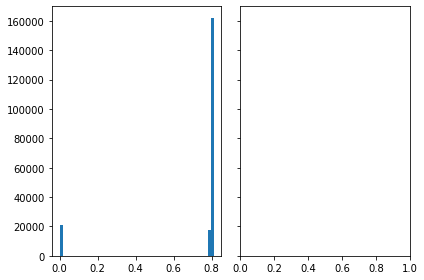

In [ ]:
run_threshold_cell = False

if run_threshold_cell:
    train_predictions = pd.read_csv(f"{init_folder}/train_predictions.csv")
    np.set_printoptions(threshold=10_000_000, precision=4, suppress=True)
    pred_df = train_predictions[["predictions"]]
    pred_df["predictions"] = pred_df["predictions"].apply(lambda x: [float(i) for i in x[1:-1].split()])

    orig_train = train_dataset.merge(train_df, how='inner', on=['case_num', 'pn_num', 'feature_num'])
    orig_train.reset_index(inplace=True, drop=True)

    true_labels_and_preds = pd.concat([orig_train, pred_df], axis=1)
    def flatten(t):
        return [item for sublist in t for item in sublist]

    print(f"Mean prediction over all classes: {np.mean(np.array(pred_df['predictions']))}")
    true_labels_and_preds["the_prds"] = true_labels_and_preds.apply(lambda x: flatten([x["predictions"][span[0]:span[1]] for span in location_list(x["location"])]), axis=1)

    # COMMENT above
    n_bins = 50
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

    dist1 = flatten(list(true_labels_and_preds["the_prds"]))
    #dist2 = 
    axs[0].hist(dist1, bins=n_bins)
    # axs[1].hist(dist2, bins=n_bins)
    fig.show()

    df = pd.DataFrame({"numbers": flatten(list(true_labels_and_preds["the_prds"]))})
    print(df.describe())

# Generate word level labels (locations) given predictions from multiple models

In [ ]:
predictions = []
weight_averages = {'roberta': 0.7944,
                   'deberta': 0.787,
                   'deberta-kaggle': 0.5}

for model_type, w in weight_averages.items():
	max_len_preds, _ = produce_same_len_predictions(model_type, "train")
    predictions.append(max_len_preds*0.5/w)

different_weights = []

for rob_w in np.arange(0.05, 0.33, 0.01):
    for deb_w in np.arange(0.33, 0.45, 0.01):
        debk_w = 1-rob_w-deb_w
        different_weights.append((rob_w, deb_w, debk_w))

weights_and_scores = []

for weights in different_weights:
    wtd_pred = [predictions[i]*weights[i] for i in range(3)]
    wtd_pred = np.sum(wtd_pred, axis=0)

    locations = np.array(train_df.apply(lambda x: get_char_locations(x["location"], x["pn_history"]), axis=1))
    true_positive = np.sum(locations*(wtd_pred >= 0.5))
    false_positive = np.sum((1-locations)*(wtd_pred >= 0.5))
    false_negative = np.sum(locations*(wtd_pred < 0.5))
    weight_f1 = true_positive / (true_positive + 0.5*(false_positive+false_negative))
    weights_and_scores.append((weight_f1, weights))

# Print 5 best weights
weights_and_scores = sorted(weights_and_scores, key=(lambda x: x[0]), reverse=True)
print(weights_and_scores[:5])


# Now with the best weights, produce predictions
best_model_weights = {'roberta': 0.1,
                      'deberta': 0.4,
                      'deberta-kaggle': 0.5}

predictions = []
for model_type, w in best_model_weights.items():
    max_len_preds, prediction_df = produce_same_len_predictions(model_type, "semi-sup")
    predictions.append(max_len_preds*w*0.5/weight_averages[model_type])

predictions = np.sum(predictions, axis=0)
prediction_df["predictions"] = predictions
semi_supervised_submissions = get_results(prediction_df)

# ONLY DO THIS for producing semi-supervised submissions as need gold labels during training
semi_supervised_submissions["gold"] = False
gold_df = train_df[["id"]]
gold_df["location"] = train_df["location"].apply(lambda x: ';'.join([f"{loc[0]} {loc[1]}" for loc in location_list(x)]))
gold_df["gold"] = True
semi_supervised_submissions = semi_supervised_submissions.append(gold_df, ignore_index=True)

semi_supervised_submissions.to_csv('../public_models/semi_supervised_submission.csv', index=False)

# Fine-tuning our model on the semi-supervised training set

In [ ]:
semi_supervised_submission = pd.read_csv('../public_models/semi_supervised_submission.csv')
semi_supervised_submission["pn_num"] = semi_supervised_submission["id"].apply(lambda x: int(x[:5]))
semi_supervised_submission["feature_num"] = semi_supervised_submission["id"].apply(lambda x: int(x[6:]))
semi_supervised_submission["case_num"] = semi_supervised_submission["id"].apply(lambda x: int(x[6:7]))
semi_supervised_submission["location"] = semi_supervised_submission["location"].apply(lambda x: x.split(';'))
semi_supervised_submission = create_k_fold_col(semi_supervised_submission)

loss_fn = nn.CrossEntropyLoss(ce_weights, reduction='sum')

for fold in range(ModelParams.n_folds):
    if ModelParams.model_type == 'roberta':
        fin_model = TokenModel('roberta-large')
    elif ModelParams.model_type == 'deberta':
        fin_model = TokenModel('microsoft/deberta-v3-large')

    fin_model.load_state_dict(torch.load(f"{init_folder}/fold_{fold}_weights/model.pth"))

    # move the model to device
    fin_model.to(device)
    # Train Model
    fin_model.train()

    # Output folder for model weights
    fold_folder = f"{fin_folder}/fold_{fold}"
    if not os.path.exists(fold_folder): os.makedirs(fold_folder)

    train_metrics_path = f"{fold_folder}/training_metrics.txt"

    fin_fold_gold_df = semi_supervised_submission[semi_supervised_submission['fold'] != fold][semi_supervised_submission['gold'] == True].copy(deep=True)
    fin_eval_gold_df = semi_supervised_submission[semi_supervised_submission['fold'] == fold][semi_supervised_submission['gold'] == True].copy(deep=True)

    fin_fold_silver_df = semi_supervised_submission[semi_supervised_submission['fold'] != fold][semi_supervised_submission['gold'] == False].copy(deep=True)
    fin_eval_silver_df = semi_supervised_submission[semi_supervised_submission['fold'] == fold][semi_supervised_submission['gold'] == False].copy(deep=True)

    # how many times the training dataset we want to use for semi-supervised training, cannot use entire set due to runtime restrictions
    n_times_train_dataset = 6
    fin_fold_df = pd.concat([fin_fold_gold_df, fin_fold_silver_df.sample \
                             (n=len(fin_fold_gold_df)*(n_times_train_dataset-1), random_state=ModelParams.rand_seed)])
    fin_eval_df = pd.concat([fin_eval_gold_df, fin_eval_silver_df.sample \
                             (n=len(fin_eval_gold_df)*(n_times_train_dataset-1), random_state=ModelParams.rand_seed)])

    fin_train_dataset = PatientNotesDataset(train_dataset, fin_fold_df, cur_tokenizer)
    fin_eval_dataset = PatientNotesDataset(train_dataset, fin_eval_df, cur_tokenizer)
    fin_train_dataloader = DataLoader(dataset=fin_train_dataset, fin_batch_size=ModelParams.fin_batch_size, shuffle=True, num_workers=ModelParams.num_workers, pin_memory=ModelParams.pin_mem)
    fin_train_eval_dataloader = DataLoader(dataset=fin_train_dataset, fin_batch_size=ModelParams.eval_batch_size, num_workers=ModelParams.num_workers, pin_memory=ModelParams.pin_mem)
    fin_eval_dataloader = DataLoader(dataset=fin_eval_dataset, fin_batch_size=ModelParams.eval_batch_size, num_workers=ModelParams.num_workers, pin_memory=ModelParams.pin_mem)

    # Optimizer and schedules for optimizer
    fin_optimizer = AdamW(fin_model.parameters(), weight_decay=0.01)
    fin_optimizer.load_state_dict(torch.load(f"{init_folder}/fold_{fold}_weights/optim.pth"))

    base_lr=2e-6      # Might need higher learning rate for here, WARNING
    num_warmup_steps=6000

    num_epochs = ModelParams.num_epochs
    num_training_steps = num_epochs * len(fin_train_dataloader)
    num_steps = 0

    best_val_loss = np.inf
    best_val_losses = []
    val_losses = []

    print(f"Fold {fold}:\n")
    progress_bar = tqdm(range(num_training_steps))
    row_format ="{:<10} {:<20} {:<15} {:<20} {:<15}"
    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    write_to_file(train_metrics_path, f"Run on {dt_string}. LR = {base_lr}, Epochs = {ModelParams.num_epochs}\n")	
    write_to_file(train_metrics_path, row_format.format("", "Approx. train loss", "Val loss", "Approx. train f1", "Val f1") + '\n')

    for epoch in range(ModelParams.num_epochs):
        fin_optimizer.param_groups[0]['lr'] = fin_optimizer.param_groups[0]['lr']*0.65
        for fin_batch in fin_train_dataloader:
            if num_steps < num_warmup_steps:
                fin_optimizer.param_groups[0]['lr'] = base_lr*(num_steps+1)/num_warmup_steps
                num_steps+=1

            num_in_batch = len(fin_batch['input_ids'])
            fin_batch = {k: v.to(device, non_blocking=True) for k, v in fin_batch.items()}
            labels = fin_batch['labels']
            del fin_batch['labels']
            outputs = init_model(fin_batch)
            loss = loss_fn(outputs, labels)/num_in_batch
            loss.backward()

            del fin_batch, labels, outputs, loss
            torch.cuda.empty_cache()

            fin_optimizer.step()
            fin_optimizer.zero_grad(set_to_none=True)
            progress_bar.update(1)

        # Every epoch print metrics, save if necessary
        fin_model.eval()
        with torch.no_grad():
            train_tp, train_fp, train_fn = 0, 0, 0

            # compute train loss
            train_loss = 0
            rand_loss_iters = set(random.sample(range(len(fin_train_eval_dataloader)), len(fin_train_eval_dataloader)//10)) # eval 0.1 of training set for approx.
            
            for count, fin_batch in enumerate(fin_train_eval_dataloader):
                if count not in rand_loss_iters: continue

                fin_batch = {k: v.to(device, non_blocking=True) for k, v in fin_batch.items()}
                labels = fin_batch['labels']
                del fin_batch['labels']

                outputs = fin_model(fin_batch)
                train_loss += loss_fn(outputs, labels)/len(rand_loss_iters)

                predictions = torch.argmax(outputs, dim=1)
                f1_metrics = calculate_f1_metrics(predictions=predictions, references=labels, attention_mask=fin_batch['attention_mask'])
                train_tp += f1_metrics[0]
                train_fp += f1_metrics[1]
                train_fn += f1_metrics[2]

            val_tp, val_fp, val_fn = 0, 0, 0

            # compute val loss and metrics
            val_loss = 0
            for fin_batch in fin_eval_dataloader:
                fin_batch = {k: v.to(device, non_blocking=True) for k, v in fin_batch.items()}
                labels = fin_batch['labels']
                del fin_batch['labels']

                outputs = fin_model(fin_batch)
                val_loss += loss_fn(outputs, labels)/len(fin_eval_dataloader)

                predictions = torch.argmax(outputs, dim=1)
                f1_metrics = calculate_f1_metrics(predictions=predictions, references=labels, attention_mask=fin_batch['attention_mask'])
                val_tp += f1_metrics[0]
                val_fp += f1_metrics[1]
                val_fn += f1_metrics[2]

            del fin_batch, outputs, labels, predictions, f1_metrics
            torch.cuda.empty_cache()

            if train_tp == 0 and train_fp == 0 and train_fn == 0: train_f1 = -1   # -1 as in weird input/error
            else: train_f1 = train_tp / (train_tp + 0.5*(train_fp+train_fn))
            if val_tp == 0 and val_fp == 0 and val_fn == 0: val_f1 = -1
            else: val_f1 = val_tp / (val_tp + 0.5*(val_fp+val_fn))
            write_to_file(train_metrics_path, row_format.format(f"Epoch {epoch+1}", f"{train_loss:.6f}", f"{val_loss:.6f}", f"{train_f1:.6f}", f"{val_f1:.6f}") + '\n')

            val_losses.append(val_loss)

            if epoch >= 7 and val_loss > (val_losses[epoch-3] + val_losses[epoch-2]*0.9 \
                                            + val_losses[epoch-1]*0.9**2)/(1+0.9+0.9**2):
                write_to_file(train_metrics_path, "\nValidation loss stopped decreasing compared to weighted average of last three epochs, stopping.\n")
                break
            
            if epoch >= 1 and val_loss < val_losses[epoch-1] and val_loss < 1.05*best_val_loss:
                best_val_loss = only_save_best_models(best_val_losses, epoch, val_loss, best_val_loss, fold_folder, fin_model)
        fin_model.train()

    for k in keys:
        if k.startswith('fin_'): del globals()[k]
    gc.collect()
    torch.cuda.empty_cache()



    # WHEN ACTUAL TRAINING CAN WATCH THEN SET NUM EPOCHS AFTER FIRST FOLD

After we decide on the best epoch numbers for each fold, keep only the weights for the best epoch

In [ ]:
# Manual Input
best_epochs = {0: 1,
               1: 0,
               2: 0,
               3: 0,
               4: 0}

# For all folds keep only the best epoch
for fold in range(ModelParams.n_folds):
    fold_folder = f"{fin_folder}/fold_{fold}"
    del_epochs = [folder.name for folder in os.scandir(fold_folder) if folder.is_dir()]
    del_epochs.remove(f"epoch_{best_epochs[fold]}")

    for del_epoch in del_epochs: shutil.rmtree(f"{fin_folder}/fold_{fold}/{del_epoch}")   # remove all directories not containing best epoch

    os.renames(f"{fin_folder}/fold_{fold}/epoch_{best_epochs[fold]}", f"{fin_folder}/fold_{fold}_weights")
    os.renames(f"{fin_folder}/fold_{fold}/training_metrics.txt", f"{fin_folder}/fold_{fold}_weights/training_metrics.txt")

Produce predictions for examples in the training set to find best weights for final model

In [ ]:
test_samples = pd.merge(train_dataset, train_df, on=['case_num', 'pn_num', 'feature_num'], how='inner')
test_dataset = TestDataset(train_dataset, test_samples, cur_tokenizer)
test_loader = DataLoader(dataset=test_dataset, batch_size=ModelParams.eval_batch_size, num_workers=ModelParams.num_workers, pin_memory=ModelParams.pin_mem)

progress_bar = tqdm(range(len(test_loader)))

predictions = []
for fold in range(ModelParams.n_folds):
    if ModelParams.model_type == 'roberta':
        initial_model = TokenModel('roberta-large')
    elif ModelParams.model_type == 'deberta':
        initial_model = TokenModel('microsoft/deberta-v3-large')

    initial_model.load_state_dict(torch.load(f"{init_folder}/fold_{fold}_weights/model.pth"))

    for param_group in initial_model.parameters():
        param_group.data = param_group.data.to(torch.float16)
    
    preds = []
    offset_mappings = []
    test_texts = []
    initial_model.eval()
    initial_model.to(device)

    for inputs in test_loader:
        offset_mappings.append(inputs['offset_mapping'].numpy())
        test_texts += inputs['text']
        del inputs['offset_mapping'], inputs['text']
        inputs = {k: v.to(device, non_blocking=True) for k, v in inputs.items()}
        with torch.no_grad():
            y_preds = initial_model(inputs)
            temp = softmax(y_preds)[:, 1, :].to('cpu').numpy()
            preds.append(temp)
        progress_bar.update(1)
    offset_mappings = np.concatenate(offset_mappings)
    token_prediction = np.concatenate(preds)

    token_prediction = token_prediction.reshape((len(test_samples), ModelParams.max_length))
    char_probs = get_char_probs(test_texts, token_prediction, offset_mappings)
    predictions.append(char_probs)
    del initial_model, token_prediction, char_probs
    torch.cuda.empty_cache()
    
predictions = np.mean(predictions, axis=0)
test_samples["predictions"] = predictions
test_samples["text"] = test_texts
test_samples.to_csv(f"{fin_folder}/train_predictions.csv", index=False)  

Finding the best weights for the final model

In [ ]:
models = ['roberta', 'deberta', 'deberta-kaggle']

predictions = []
for model_type in models:
    max_len_preds, prediction_df = produce_same_len_predictions(model_type, "semi-sup", training_section="final")
    predictions.append(thing)

different_weights = []
for rob_w in np.arange(0.05, 0.33, 0.01):
    for deb_w in np.arange(0.33, 0.45, 0.01):
        debk_w = 1-rob_w-deb_w
        different_weights.append((rob_w, deb_w, debk_w))

weights_and_scores = []

for weights in different_weights:
    new_pred = [predictions[i]*weights[i] for i in range(3)]
    new_pred = np.sum(new_pred, axis=0)

    locations = np.array(train_df.apply(lambda x: get_char_locations(x["location"], x["pn_history"]), axis=1))
    true_positive = np.sum(locations*(new_pred >= 0.5))
    false_positive = np.sum((1-locations)*(new_pred >= 0.5))
    false_negative = np.sum(locations*(new_pred < 0.5))
    weight_f1 = true_positive / (true_positive + 0.5*(false_positive+false_negative))
    weights_and_scores.append((weight_f1, weights))
weights_and_scores = sorted(weights_and_scores, key=(lambda x: x[0]), reverse=True)
print(weights_and_scores[:5])